In [1]:
import json
import csv
states = ["ak","al","ar","az","ca","co","ct","de","fl","ga","hi","ia","id","il",
          "in","ks","ky","la","ma","md","me","mi","mn","mo","ms","mt","nc","nd","ne","nh",
          "nj","nm","nv","ny","oh","ok","or","pa","ri","sc","sd","tn","tx","ut","va","vt",
          "wa","wi","wv","wy"]

states_names = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado',
'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois',
'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana',
'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC':'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island',
'SC': 'South Carolina', 'SD': 'South Dakota', 'TN':'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia',
'WA': 'Washington','WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}


In [2]:
def getState(data):
    if data["place"] != None and data["place"]["country_code"] == "US":
        state = str(data["place"]["full_name"]).lower().split(", ")
        if len(state) > 1:
            return state[1]

def isState(state):
    if state in states:
        return True
    return False 
   

In [3]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd
import config
MAP_PATH = config.map_path
%matplotlib inline

print(gpd.datasets.available)

usa = gpd.read_file(MAP_PATH)
usa.head()

['naturalearth_cities', 'naturalearth_lowres', 'nybb']


,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,(POLYGON ((-160.0738033454681 22.0041773479577...
1,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...
2,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...
3,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...
4,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...


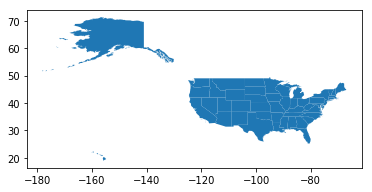

In [4]:
usa.plot()

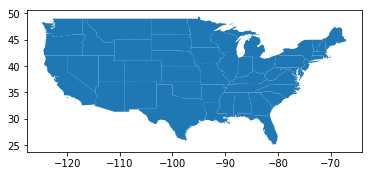

In [5]:
# Exclude Alaska and Hawaii
usa[usa['STATE_NAME'].isin(['Alaska','Hawaii']) == False].plot()
usa = usa[usa['STATE_NAME'].isin(['Alaska','Hawaii']) == False]

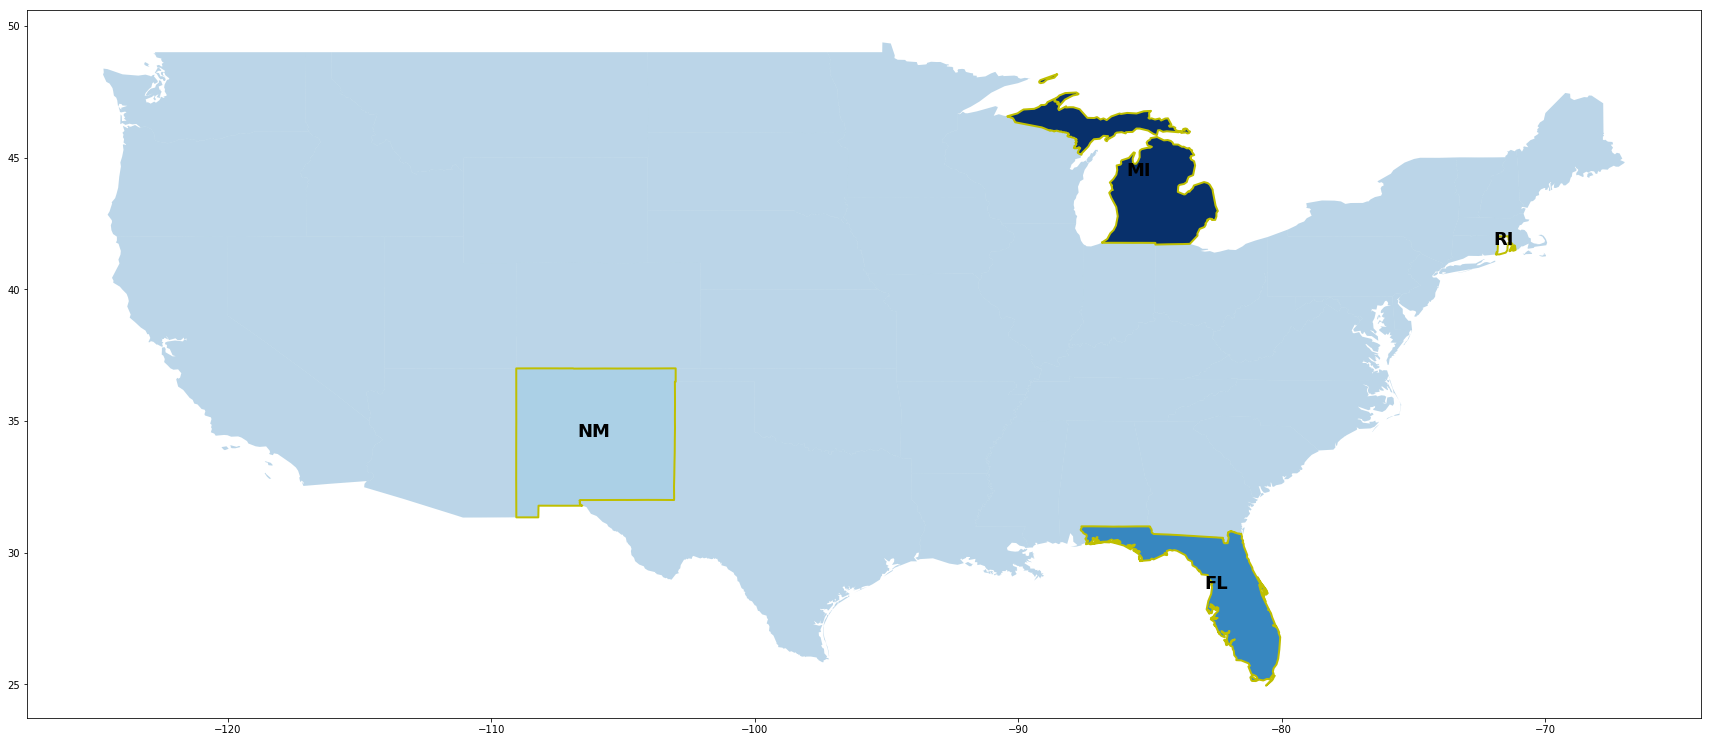

In [6]:
def plot_states(states):
    fig, ax = plt.subplots(figsize = (30, 30))
    usa.plot(ax=ax, alpha = 0.3)
    ndf = usa[usa['STATE_ABBR'].isin(states) == True]
    ndf.plot(ax = ax, cmap='Blues', edgecolor = 'y', linewidth = 2)
    ndf.apply(lambda x: ax.annotate(s = x.STATE_ABBR, xy = x.geometry.centroid.coords[0], ha = 'center', weight='bold', size=18), axis = 1)
    
plot_states(['RI', 'NM', 'MI', 'FL'])

In [7]:
PROJECT_PATH = config.data_directory

def scoresFromFile(termScoreFile):
    scores = {}
    with open(termScoreFile, 'r') as f:
        for line in f:
            term, score = line.split("\t")
            scores[term] = float(score)
    return scores

setScores = scoresFromFile('{}/{}.txt'.format(PROJECT_PATH, "AFINN-111"))

In [8]:
import spacy
nlp = spacy.load('en')

def getTokens(text):
    doc = nlp(text)
    words_set = set([token.text.lower() for token in doc])
    stopwords_set = set(spacy.lang.en.stop_words.STOP_WORDS)
    contentWords = [w for w in words_set if w.lower() not in stopwords_set]
    
    return contentWords

def readTweets(filename):
    sentiments = {}
    with open(filename, "r") as ins:
        for line in ins:
            if (len(line)> 1): ## to avoid empty lines 
                data = json.loads(line)
                if "created_at" in data:
                    state = getState(data)
                else:
                    continue
                if isState(state):
                    if "text" in data:
                        sentiment = 0.0
                        for eachWord in getTokens(data["text"]):
                            if eachWord in setScores:
                                sentiment += setScores[eachWord]
                        sentiments[state.upper()] = sentiment
    return sentiments

tsentiments = readTweets("output.txt")

In [9]:
max(zip(setScores.values(), setScores.keys()))

(5.0, 'thrilled')

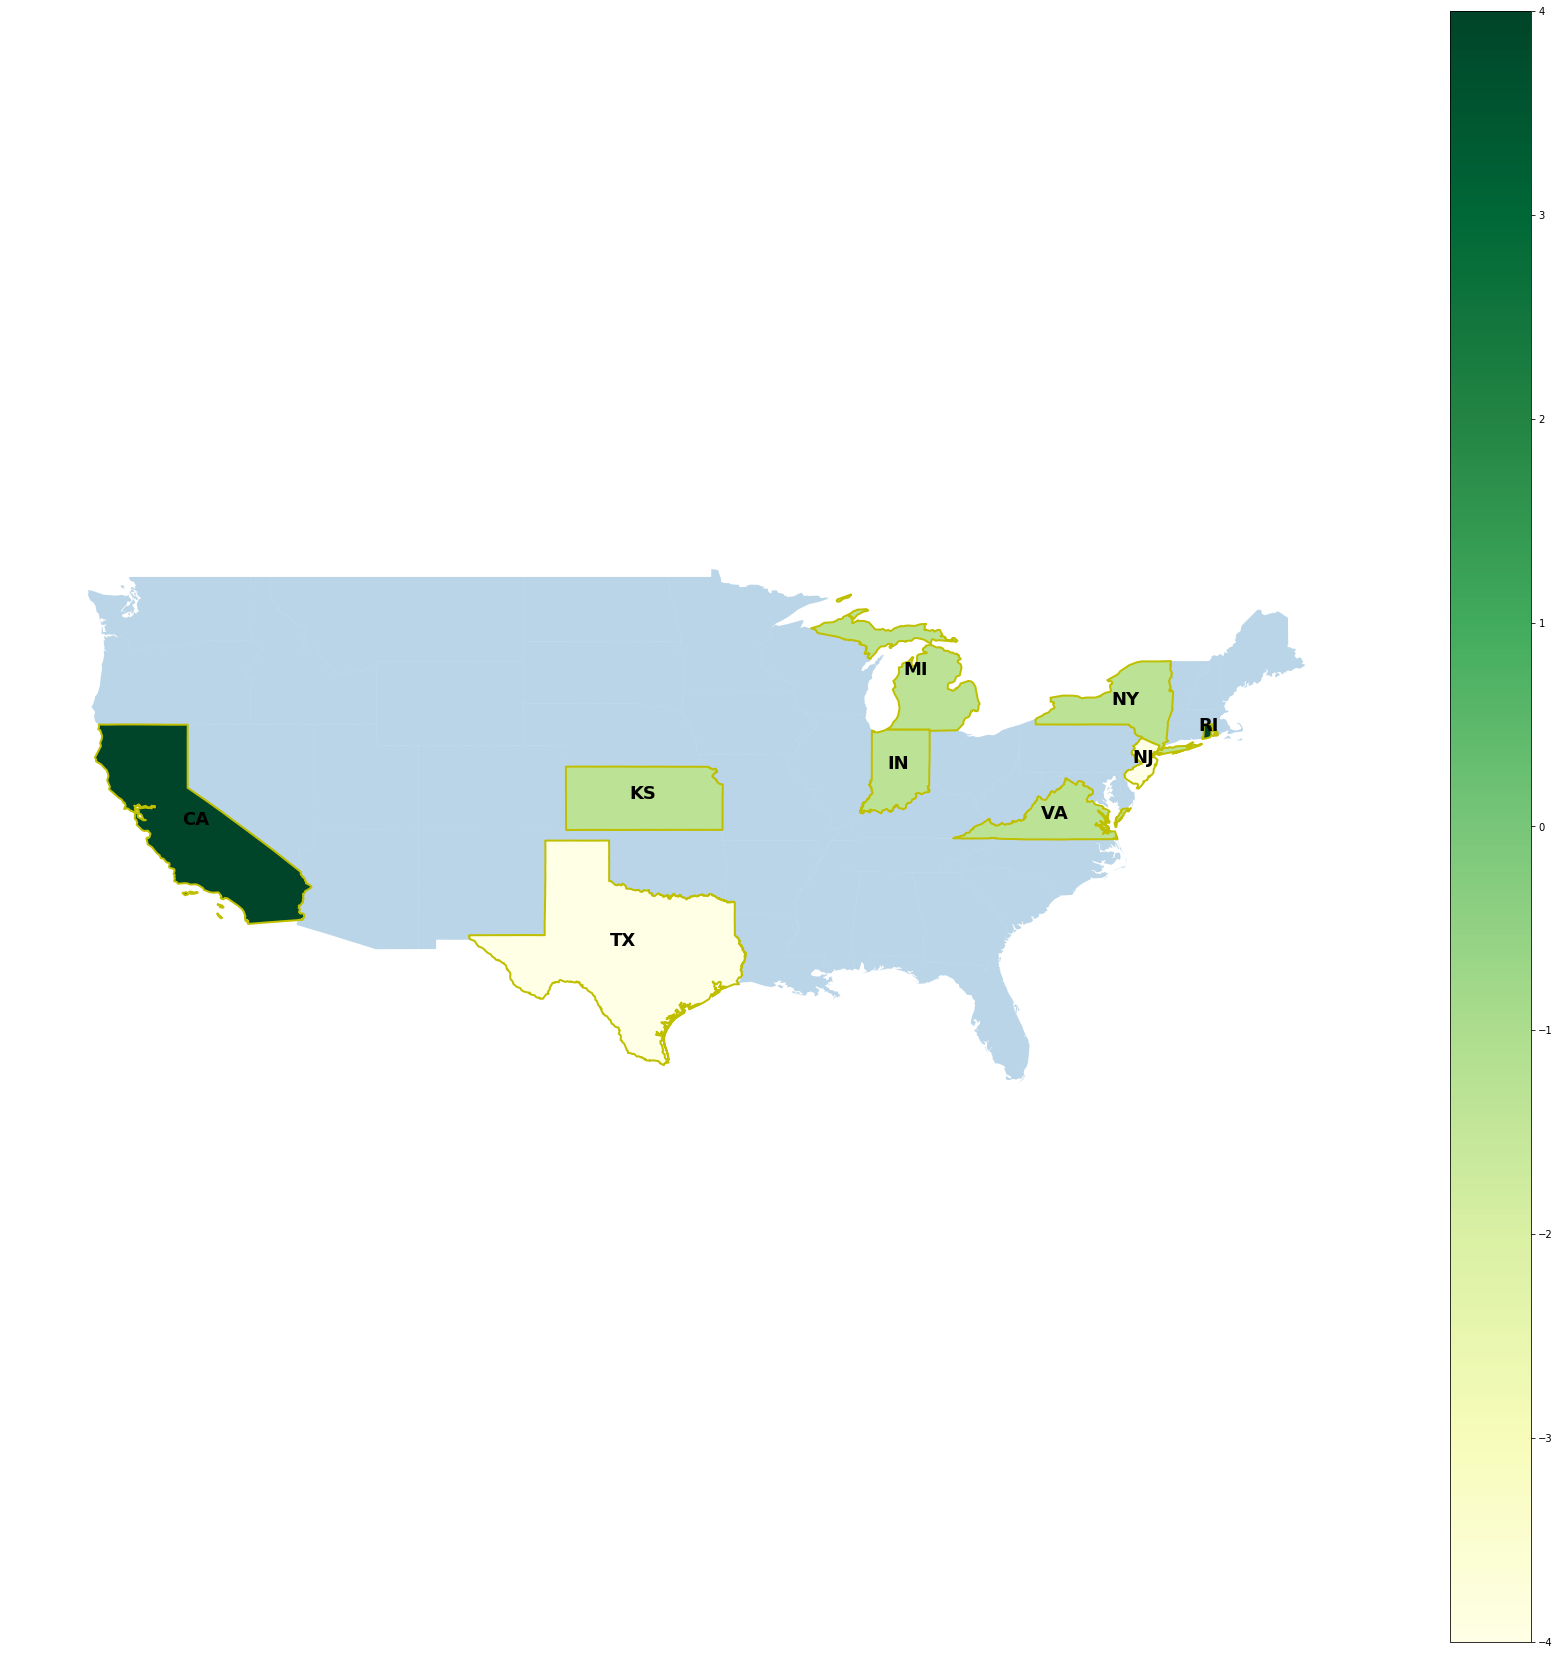

In [12]:
def plot_states_sentiments(sentiments):
    fig, ax = plt.subplots(figsize = (30, 30))
    usa.plot(ax=ax, alpha = 0.3)
    ax.axis('off')
    states = [s for s in sentiments]
    ndf = usa[usa['STATE_ABBR'].isin(states) == True].copy()
    ndf['STATE_SENT'] = 0.0
    for index, row in ndf.iterrows():
        ndf.loc[index, 'STATE_SENT'] = sentiments[row['STATE_ABBR']]
        
    sm = plt.cm.ScalarMappable(cmap='YlGn', norm=plt.Normalize(vmin=ndf['STATE_SENT'].min(), vmax=ndf['STATE_SENT'].max()))
    sm._A = []
    fig.colorbar(sm)
    kw = dict(column='STATE_SENT', k=6, cmap='YlGn')
    ndf.plot(ax = ax, edgecolor = 'y', linewidth = 2, scheme='QUANTILES', **kw)
    ndf.apply(lambda x: ax.annotate(s = x.STATE_ABBR, xy = x.geometry.centroid.coords[0], ha = 'center', weight='bold', size=18), axis = 1)

plot_states_sentiments(tsentiments)